# [Implementation and application patterns for explaining methods]()
-------
#### Software chapter of the "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning" book 
--------

This is the accompanying code for the software chapter of the book "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning". For a more detailed understanding please have a look into the chapter: [TODO: Add link.]().

-------

## Section 3.1: Miss-predictions of digit 3

This notebook shows how saliency maps can be computed for miss-predicted samples.
We will train a classifier on MNIST and then analyze the miss-predicition of the letter 3 on the test set w.r.t. to the digits 2, 3, 4, 5, and 6.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

Using TensorFlow backend.


## Data
Load the dataset and keep some images from the test set for the analysis.

In [3]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

## Model
The next part trains and evaluates a CNN.

In [4]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

scores = mnistutils.train_model(model, data, batch_size=128, epochs=10)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Epoch 1/10
60000/60000 [==============================] - 9s 151us/step - loss: 0.1292 - acc: 0.9605
Epoch 2/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.0349 - acc: 0.9891
Epoch 3/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.0199 - acc: 0.9935
Epoch 4/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0140 - acc: 0.9956
Epoch 5/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0098 - acc: 0.9968
Epoch 6/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0082 - acc: 0.9973
Epoch 7/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.0073 - acc: 0.9974
Epoch 8/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0049 - acc: 0.9985
Epoch 9/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0039 - acc: 0.9988
Epoch 10/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.0070 - acc: 0.997

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [5]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    ("occlusion",             {},                       mnistutils.heatmap,        "Occlusion 3x3 patches"),
    #("lime",                  {},                       mnistutils.heatmap,        "LIME"),
 
    # Function
    ("gradient",              {"postprocess": "abs"},   mnistutils.heatmap,        "Gradient"),
    ("smoothgrad",            {"noise_scale": noise_scale,
                               "postprocess": "square"},mnistutils.heatmap,        "SmoothGrad"),

    # Signal
    ("deconvnet",             {},                       mnistutils.heatmap,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.heatmap,        "Guided Backprop",),


    # Interaction
    ("input_t_gradient",      {},                       mnistutils.heatmap,        "Input * Gradient"),
    ("integrated_gradients",  {"reference_inputs": ri}, mnistutils.heatmap,        "Integrated Gradients"),
    #("deep_lift.wrapper",     {"reference_inputs": ri}, mnistutils.heatmap,        "DeepLIFT Wrapper - Rescale"),
    #("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"},
    #                                                    mnistutils.heatmap,        "DeepLIFT Wrapper - RevealCancel"),
    ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"),
    ("lrp.sequential_preset_a_flat",{"epsilon": 1},     mnistutils.heatmap,        "LRP-*"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"), 
    ("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
    ("pattern.net",           {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"),
]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [6]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(
            method[0],                     # analysis method identifier
            model_wo_softmax,              # model without softmax output
            neuron_selection_mode="index", # We want to select the output neuron to analyze.
            **method[1])                   # optional analysis parameters
        # Some analyzers require training.
        analyzer.fit(data[0], batch_size=256, verbose=1)
    except:
        analyzer = None
    analyzers.append(analyzer)

W0403 12:03:50.893941 22423928821568 deprecation.py:506] From /home/alber/repos/interpretable_ai_book__sw_chapter/innvestigate/innvestigate/utils/keras/backend.py:126: calling extract_image_patches (from tensorflow.python.ops.array_ops) with ksizes is deprecated and will be removed in a future version.
Instructions for updating:
ksizes is deprecated, use sizes instead


Epoch 1/1
235/235 [==============================] - 5s 23ms/step - loss: 4.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000
Epoch 1/1
235/235 [==============================] - 6s 24ms/step - loss: 4.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000 - broadcast_7_loss: 1.0000 - broadcast_8_loss: 1.0000


Adding occlusion and LIME code from implemention.ipynb.

In [7]:
def run_occlusion(model, x, psize, neuron):
    diff = np.zeros_like(x)

    # Occlude patch by patch and calculate activation for each patch
    for i in range(0, x.shape[1], psize):
        for j in range(0, x.shape[2], psize):

            # Create image with the patch occluded
            occluded_x = x.copy()
            occluded_x[:, i:i+psize, j:j+psize, :] = 0

            # Store activation of occluded image
            diff[:, i:i+psize, j:j+psize, :] = model.predict(occluded_x)[0, neuron]

    # Normalize with initial activation value
    A3 = model.predict(x)[0, neuron] - diff
    return A3
    
def run_lime(model, x, num_samples, neuron):
    import lime.lime_image
    exp = lime.lime_image.LimeImageExplainer()
    def f(tmp):
        return model.predict(tmp[:, :, :, 0:1])[:, neuron].reshape((-1, 1))

    explanation = exp.explain_instance(x[0].repeat(3, axis=-1), f, hide_color=0, num_samples=num_samples, labels=(0,), top_labels=None)

    segment_id_and_weight = explanation.local_exp[0]
    segments = explanation.segments

    tmp = np.zeros_like(x)
    for segment_id, w in segment_id_and_weight:
        tmp[0][segments == segment_id] = w
    return tmp

Now we analyze each image with the different analyzers on the specified output neurons:

--------------------------------------------------------------------------------
Image nr. 0: 
Saving figure to mnist_missprediction_0.pdf


<Figure size 432x288 with 0 Axes>

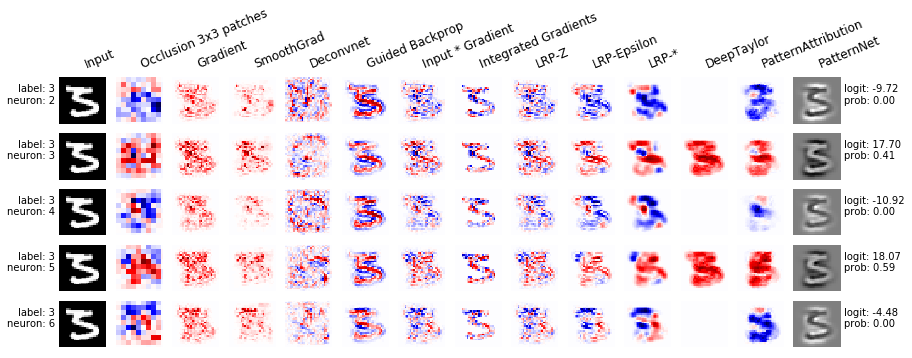

--------------------------------------------------------------------------------
Image nr. 1: 
Saving figure to mnist_missprediction_1.pdf


<Figure size 432x288 with 0 Axes>

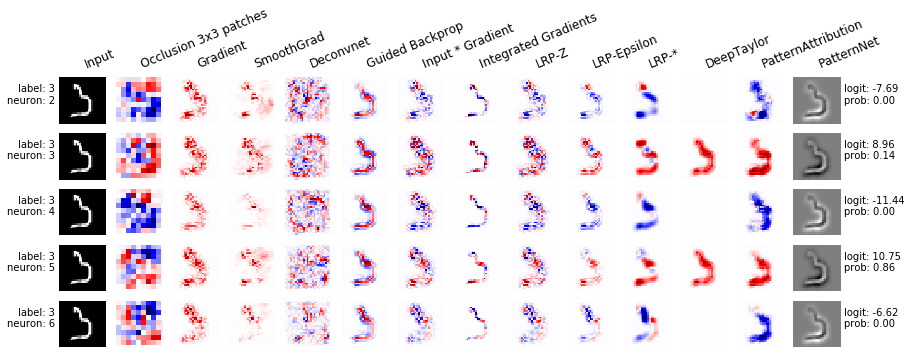

--------------------------------------------------------------------------------
Image nr. 2: 
Saving figure to mnist_missprediction_2.pdf


<Figure size 432x288 with 0 Axes>

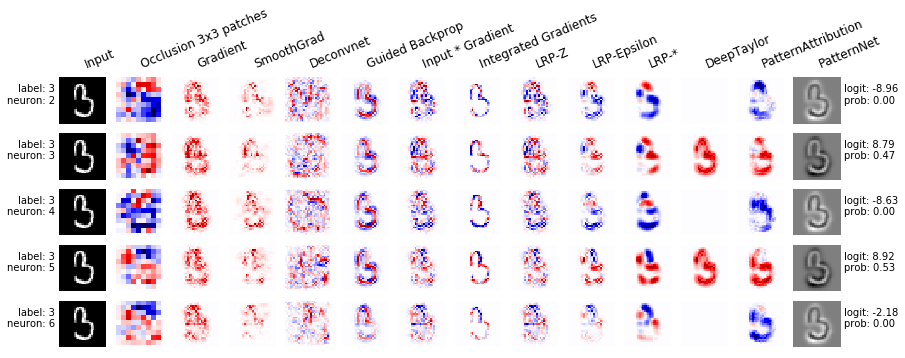

--------------------------------------------------------------------------------
Image nr. 3: 
Saving figure to mnist_missprediction_3.pdf


<Figure size 432x288 with 0 Axes>

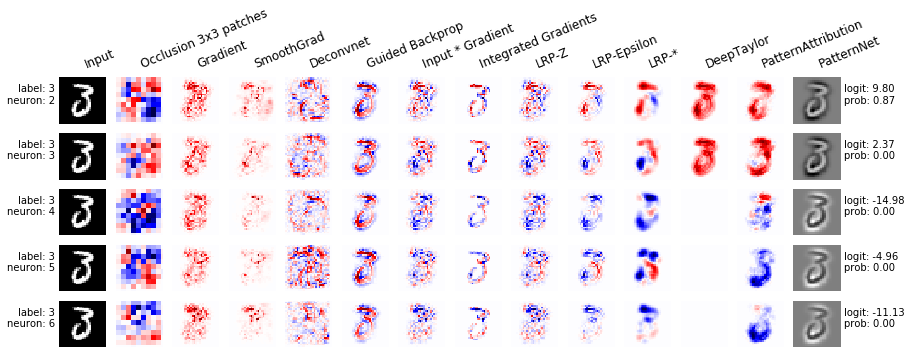

--------------------------------------------------------------------------------
Image nr. 4: 
Saving figure to mnist_missprediction_4.pdf


<Figure size 432x288 with 0 Axes>

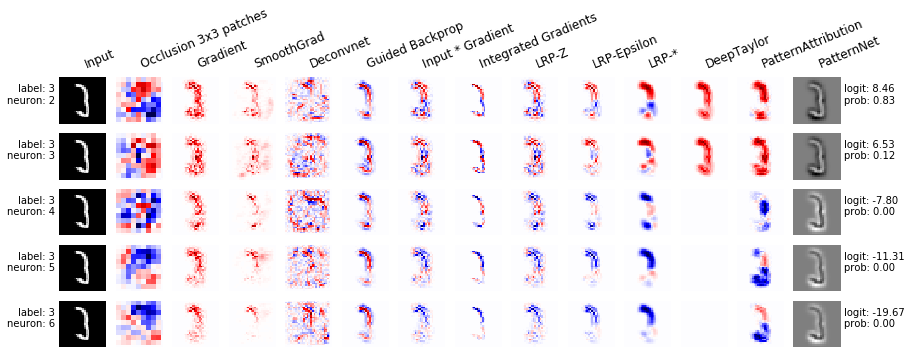

--------------------------------------------------------------------------------
Image nr. 5: 
Saving figure to mnist_missprediction_5.pdf


<Figure size 432x288 with 0 Axes>

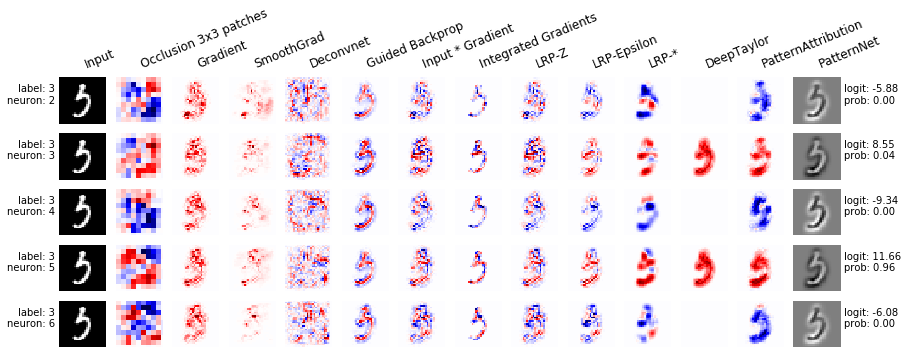

--------------------------------------------------------------------------------
Image nr. 6: 
Saving figure to mnist_missprediction_6.pdf


<Figure size 432x288 with 0 Axes>

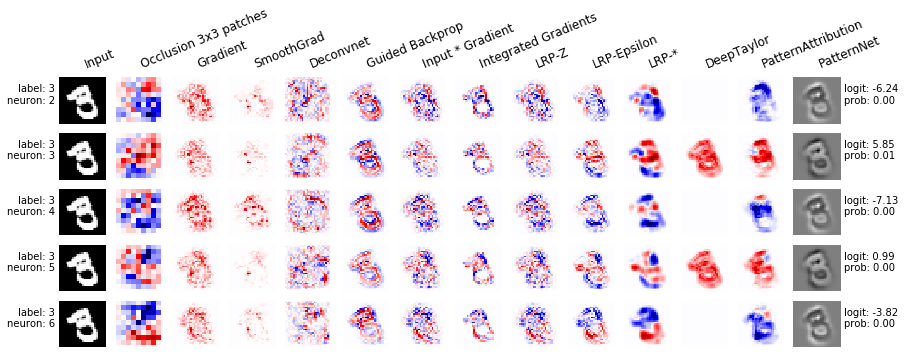

--------------------------------------------------------------------------------
Image nr. 7: 
Saving figure to mnist_missprediction_7.pdf


<Figure size 432x288 with 0 Axes>

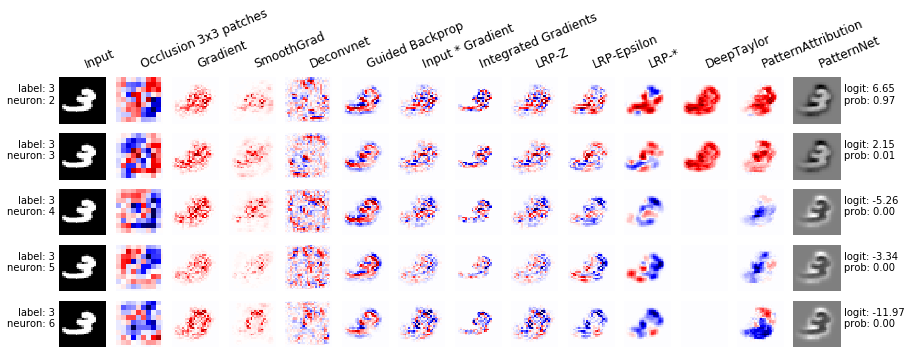

In [8]:
# Gather indices for miss-classifications
wrong_classified = np.flatnonzero(model.predict(data[2]).argmax(axis=1) != data[3])
# for samples with true label 3
indices = [i for i in wrong_classified[:] if data[3][i] == 3]
# Get the according images
test_images = list(zip(data[2][indices], data[3][indices]))

for image_nr, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([5, len(analyzers), 28, 28, 3])
    text = []

    for ii, output_neuron in enumerate([2, 3, 4, 5, 6]): #range(num_classes):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            if methods[aidx][0] in "occlusion":
                a = run_occlusion(model_wo_softmax, x, 3, output_neuron)
            elif methods[aidx][0] in "lime":
                a = run_lime(model_wo_softmax, x, 100, output_neuron)
            else:
                a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}: ".format(image_nr))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", "mnist_missprediction.pdf")
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i." % image_nr)+file_name.split(".")[-1]
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, file_name=file_name)

Each column shows the visualized results for different analyzers and each row shows the analyses w.r.t. to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).